**Chapter 10 – Introduction to Artificial Neural Networks with Keras**

_This notebook contains all the sample code and solutions to the exercises in chapter 10._

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
#import sklearn
#assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Activation functions

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Saving figure activation_functions_plot


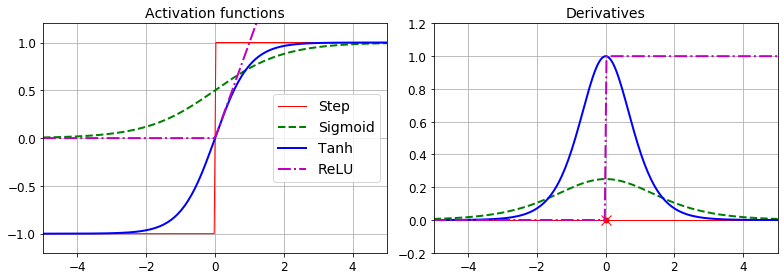

In [3]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

In [4]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

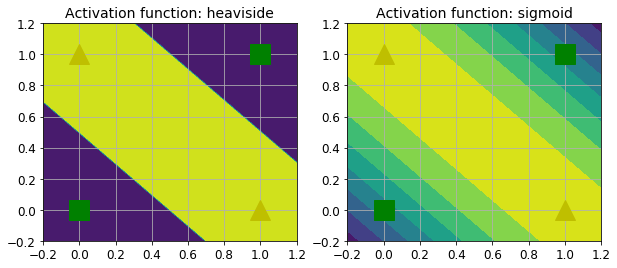

In [5]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

# Building an Image Classifier

First let's import TensorFlow and Keras.

In [6]:
import tensorflow as tf
from tensorflow import keras

In [7]:
tf.__version__

'2.2.0'

In [8]:
keras.__version__

'2.3.0-tf'

Check for mkl support

In [9]:
try:
    tf.python.framework.test_util.IsMklEnabled()
except:
    from tensorflow.python import pywrap_tensorflow; print(pywrap_tensorflow.IsMklEnabled())

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to
et and a test set, but it can be useful to split the training set further to have a validation set:

In [10]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [11]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [12]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [13]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

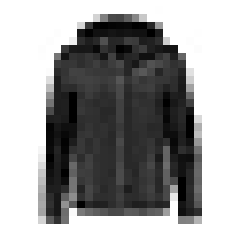

In [14]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [15]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [16]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [17]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [18]:
X_valid.shape

(5000, 28, 28)

In [19]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

Saving figure fashion_mnist_plot


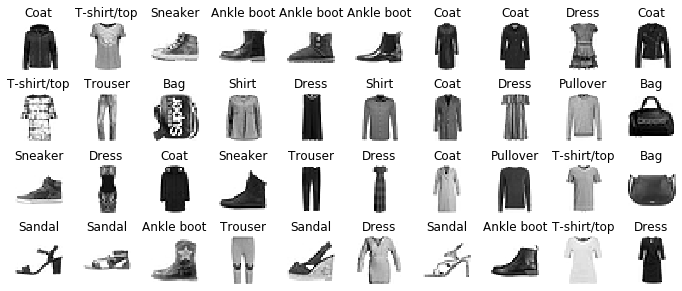

In [20]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [21]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [22]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [23]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [24]:
model.layers

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


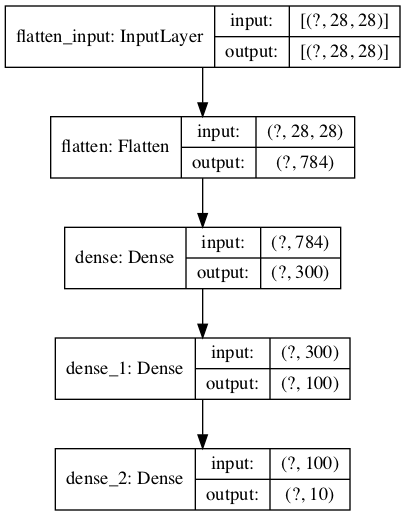

In [26]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [27]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [28]:
model.get_layer(hidden1.name) is hidden1

True

In [29]:
weights, biases = hidden1.get_weights()

In [30]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [31]:
weights.shape

(784, 300)

In [32]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [33]:
biases.shape

(300,)

In [34]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [35]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 8s 5ms/step - loss: 0.7237 - accuracy: 0.7643 - val_loss: 0.5213 - val_accuracy: 0.8226
Epoch 2/30
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4843 - accuracy: 0.8317 - val_loss: 0.4350 - val_accuracy: 0.8536
Epoch 3/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4392 - accuracy: 0.8456 - val_loss: 0.5355 - val_accuracy: 0.7970
Epoch 4/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4123 - accuracy: 0.8566 - val_loss: 0.3919 - val_accuracy: 0.8650
Epoch 5/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3937 - accuracy: 0.8618 - val_loss: 0.3741 - val_accuracy: 0.8686
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3750 - accuracy: 0.8675 - val_loss: 0.3720 - val_accuracy: 0.8730
Epoch 7/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3632 - accuracy: 0.8715 - val_loss: 0.3614 - val_accuracy:

In [ ]:
history.params

In [ ]:
print(history.epoch)

In [ ]:
history.history.keys()

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

In [ ]:
y_pred = model.predict_classes(X_new)
y_pred

In [ ]:
np.array(class_names)[y_pred]

In [ ]:
y_new = y_test[:3]
y_new

In [ ]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# Regression MLP

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

In [ ]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
y_pred

# Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [ ]:
model.summary()

In [ ]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Adding an auxiliary output for regularization:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [ ]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

In [ ]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

In [ ]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

# The subclassing API

In [ ]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [ ]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

In [ ]:
model = WideAndDeepModel(30, activation="relu")

# Saving and Restoring

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

In [ ]:
model.save("my_keras_model.h5")

In [ ]:
model = keras.models.load_model("my_keras_model.h5")

In [ ]:
model.predict(X_new)

In [ ]:
model.save_weights("my_keras_weights.ckpt")

In [ ]:
model.load_weights("my_keras_weights.ckpt")

# Using Callbacks during Training

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

In [ ]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [ ]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

# TensorBoard

In [ ]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [ ]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [ ]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

To start the TensorBoard server, one option is to open a terminal, if needed activate the virtualenv where you installed TensorBoard, go to this notebook's directory, then type:

```bash
$ tensorboard --logdir=./my_logs --port=6006
```

You can then open your web browser to [localhost:6006](http://localhost:6006) and use TensorBoard. Once you are done, press Ctrl-C in the terminal window, this will shutdown the TensorBoard server.

Alternatively, you can load TensorBoard's Jupyter extension and run it like this:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

In [ ]:
run_logdir2 = get_run_logdir()
run_logdir2

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.05))

In [ ]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Notice how TensorBoard now sees two runs, and you can compare the learning curves.

Check out the other available logging options:

In [ ]:
help(keras.callbacks.TensorBoard.__init__)

# Hyperparameter Tuning

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [ ]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [ ]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [ ]:
mse_test = keras_reg.score(X_test, y_test)

In [ ]:
y_pred = keras_reg.predict(X_new)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

**Warning**: the following cell crashes at the end of training. This seems to be caused by [Keras issue #13586](https://github.com/keras-team/keras/issues/13586), which was triggered by a recent change in Scikit-Learn. [Pull Request #13598](https://github.com/keras-team/keras/pull/13598) seems to fix the issue, so this problem should be resolved soon.

In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [ ]:
rnd_search_cv.best_params_

In [ ]:
rnd_search_cv.best_score_

In [ ]:
rnd_search_cv.best_estimator_

In [ ]:
rnd_search_cv.score(X_test, y_test)

In [ ]:
model = rnd_search_cv.best_estimator_.model
model

In [ ]:
model.evaluate(X_test, y_test)

# Exercise solutions

## 1. to 9.

See appendix A.

## 10.

*Exercise: Train a deep MLP on the MNIST dataset (you can load it using `keras.datasets.mnist.load_data()`. See if you can get over 98% precision. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). Try adding all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.*

Let's load the dataset:

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

Just like for the Fashion MNIST dataset, the MNIST training set contains 60,000 grayscale images, each 28x28 pixels:

In [ ]:
X_train_full.shape

Each pixel intensity is also represented as a byte (0 to 255):

In [ ]:
X_train_full.dtype

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255, just like we did for Fashion MNIST:

In [ ]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Let's plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

In [ ]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9. Conveniently, the class IDs correspond to the digits represented in the images, so we don't need a `class_names` array:

In [ ]:
y_train

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [ ]:
X_valid.shape

In [ ]:
X_test.shape

Let's take a look at a sample of the images in the dataset:

In [ ]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

In [ ]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration:

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

Now let's train the model for just 1 epoch:

In [ ]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

We can now plot the loss as a functionof the learning rate:

In [ ]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("Loss")

The loss starts shooting back up violently around 3e-1, so let's try using 2e-1 as our learning rate:

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=2e-1),
              metrics=["accuracy"])

In [ ]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, checkpoint_cb, tensorboard_cb])

In [ ]:
model = keras.models.load_model("my_mnist_model.h5") # rollback to best model
model.evaluate(X_test, y_test)

We got over 98% accuracy. Finally, let's look at the learning curves using TensorBoard:

In [ ]:
%tensorboard --logdir=./my_mnist_logs --port=6006